<a href="https://colab.research.google.com/github/moa101/seq2seq/blob/master/Sequence_to_Sequence_Learning_with_Tensor2Tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence to Sequence Learning with Tensor2Tensor


This notebook was created for PhD Open lectures given in June 2018 at the University of Warsaw. The slides for the lectures are available [here](http://phdopen.mimuw.edu.pl/lato18/w5s/DeepLearning.pdf) and the full recording [here on YouTube](https://www.youtube.com/channel/UCvMN-HLvvVa6lUXijCKFlqQ) - take a look at it if you need more explanation!

In [0]:
# Install deps.
!pip install -q -U tensor2tensor
!pip install -q tensorflow matplotlib


In [2]:
!t2t-trainer  --generate_data \
  --data_dir=~/t2t_data \
  --output_dir=~/t2t_train/mnist \
  --problem=image_mnist \
  --model=shake_shake \
  --hparams_set=shake_shake_quick \
  --train_steps=1000 \
  --eval_steps=100

:::MLPv0.5.0 transformer 1541815090.827306032 (/usr/local/bin/t2t-trainer:28) run_start
:::MLPv0.5.0 transformer 1541815090.827846050 (/usr/local/bin/t2t-trainer:28) run_set_random_seed
INFO:tensorflow:Generating data for image_mnist
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /tmp/t2t_datagen/train-images-idx3-ubyte.gz
100% completed
INFO:tensorflow:Successfully downloaded train-images-idx3-ubyte.gz, 9912422 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /tmp/t2t_datagen/train-labels-idx1-ubyte.gz
113% completed
INFO:tensorflow:Successfully downloaded train-labels-idx1-ubyte.gz, 28881 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /tmp/t2t_datagen/t10k-images-idx3-ubyte.gz
100% completed
INFO:tensorflow:Successfully downloaded t10k-images-idx3-ubyte.gz, 1648877 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/t10k-labels

In [3]:
# Imports we need.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections
import random
import six

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_attention
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics
from tensor2tensor.utils import learning_rate
from tensor2tensor.utils import optimize

# TF session
sess = tf.Session()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"

/usr/local/lib/python2.7/dist-packages/tensor2tensor/data_generators/video_generated.py:34: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/applica

# Download MNIST and inspect it

In [4]:
# Fetch the MNIST problem
mnist_problem = problems.problem("image_mnist")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
mnist_problem.generate_data(data_dir, tmp_dir)

INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /root/t2t/tmp/train-images-idx3-ubyte.gz
100% completed
INFO:tensorflow:Successfully downloaded train-images-idx3-ubyte.gz, 9912422 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /root/t2t/tmp/train-labels-idx1-ubyte.gz
113% completed
INFO:tensorflow:Successfully downloaded train-labels-idx1-ubyte.gz, 28881 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /root/t2t/tmp/t10k-images-idx3-ubyte.gz
100% completed
INFO:tensorflow:Successfully downloaded t10k-images-idx3-ubyte.gz, 1648877 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to /root/t2t/tmp/t10k-labels-idx1-ubyte.gz
180% completed
INFO:tensorflow:Successfully downloaded t10k-labels-idx1-ubyte.gz, 4542 bytes.
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-images-idx3-ubyte.

INFO:tensorflow:Reading data files from /root/t2t/data/image_mnist-train*
INFO:tensorflow:partition: 0 num_data_files: 10
:::MLPv0.5.0 transformer 1541815572.724098921 (<ipython-input-6-55840b779871>:1) input_order
Label: 1


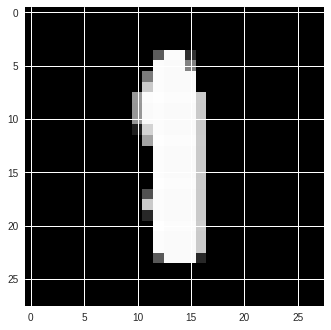

In [6]:
# Now let's see the training MNIST data as Tensors.
mnist_data = mnist_problem.dataset(Modes.TRAIN, data_dir)
mnist_example_tensors = mnist_data.make_one_shot_iterator().get_next()
mnist_example = sess.run(mnist_example_tensors)
image = mnist_example["inputs"]
label = mnist_example["targets"]

plt.imshow(image[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
print("Label: %d" % label)

# Basic MNIST model.

In [0]:
# One-off all code together.

# Data.
BATCH_SIZE = 100
data_batches = mnist_data.repeat().batch(BATCH_SIZE).make_one_shot_iterator()
batch = data_batches.get_next()
x, y = batch["inputs"], batch["targets"]
x = tf.reshape(x, [BATCH_SIZE, 28*28])  # Height and width on channels.
y = tf.squeeze(y, axis=1)  # Bogus dimension.
# Model.
hidden_size = 128
h = tf.layers.dense(x, hidden_size, activation=tf.nn.relu, name="hidden")
o = tf.layers.dense(h, 10, activation=tf.nn.relu, name="output")
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o, labels=y)
accuracy = tf.to_float(tf.equal(tf.argmax(o, axis=-1), y))
loss_t, accuracy_t = tf.reduce_mean(loss), tf.reduce_mean(accuracy)
# Gradients.
train_op = tf.train.AdamOptimizer().minimize(loss_t)
sess.run(tf.global_variables_initializer())

In [8]:
# Train.
num_steps = 1200  #  2 epochs on 60K examples.
for step in range(num_steps):
  _, loss, accuracy = sess.run([train_op, loss_t, accuracy_t])
  if step % 100 == 0:
    print("Step %d loss %.4f accuracy %.2f" % (step, loss, accuracy))

Step 0 loss 2.8189 accuracy 0.07
Step 100 loss 0.5726 accuracy 0.81
Step 200 loss 0.2678 accuracy 0.92
Step 300 loss 0.2792 accuracy 0.92
Step 400 loss 0.1361 accuracy 0.97
Step 500 loss 0.0879 accuracy 0.97
Step 600 loss 0.1535 accuracy 0.95
Step 700 loss 0.1934 accuracy 0.96
Step 800 loss 0.1619 accuracy 0.96
Step 900 loss 0.1374 accuracy 0.95
Step 1000 loss 0.1615 accuracy 0.95
Step 1100 loss 0.0803 accuracy 0.98


In [9]:
# Once again, all refactored and with reset.

# Reset.
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Data.
problem = problems.problem("image_mnist")
problem.generate_data(data_dir, tmp_dir)
BATCH_SIZE = 100
train_data = problem.dataset(Modes.TRAIN, data_dir)
train_batches = train_data.repeat().batch(BATCH_SIZE)
train_batch = train_batches.make_one_shot_iterator().get_next()
eval_data = problem.dataset(Modes.EVAL, data_dir)
eval_batches = eval_data.repeat().batch(BATCH_SIZE)
eval_batch = eval_batches.make_one_shot_iterator().get_next()

# Model
def model(batch, mode):
  with tf.variable_scope("mymodel", reuse=mode == Modes.EVAL):
    # Inputs.
    x, y = batch["inputs"], batch["targets"]
    x = tf.reshape(x, [BATCH_SIZE, 28*28])  # Height and width on channels.
    y = tf.squeeze(y, axis=1)  # Bogus dimension.
    # Body.
    hidden_size = 128
    h = tf.layers.dense(x, hidden_size, activation=tf.nn.relu, name="hidden")
    o = tf.layers.dense(h, 10, activation=tf.nn.relu, name="output")
    # Loss and accuracy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o, labels=y)
    accuracy = tf.to_float(tf.equal(tf.argmax(o, axis=-1), y))
    return tf.reduce_mean(loss), tf.reduce_mean(accuracy)

# Model for train.
train_loss, train_accuracy = model(train_batch, Modes.TRAIN)
# Gradients.
train_op = tf.train.AdamOptimizer().minimize(train_loss)
# Model for eval.
eval_loss, eval_accuracy = model(eval_batch, Modes.EVAL)

INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/t10k-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-labels-idx1-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/t10k-images-idx3-ubyte.gz
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Skipping generator because outputs files exists at ['/root/t2t/data/image_mnist-unshuffled-train-00000-of-00010', '/root/t2t/data/image_mnist-unshuffled-train-00001-of-00010', '/root/t2t/data/image_mnist-unshuffled-train-00002-of-00010'

In [11]:
# Train.
sess.run(tf.global_variables_initializer())
num_steps = 2400  #  4 epochs on 60K examples.
for step in range(num_steps + 1):
  _, loss, accuracy = sess.run([train_op, train_loss, train_accuracy])
  if step % 100 == 0:
    print("Step %d train loss %.4f accuracy %.2f" % (step, loss, accuracy))
    loss, accuracy = sess.run([eval_loss, eval_accuracy])
    print("Step %d eval loss %.4f accuracy %.2f" % (step, loss, accuracy))


Step 0 train loss 2.6255 accuracy 0.10
Step 0 eval loss 2.2762 accuracy 0.21
Step 100 train loss 0.3214 accuracy 0.92
Step 100 eval loss 0.3057 accuracy 0.91
Step 200 train loss 0.3334 accuracy 0.93
Step 200 eval loss 0.2190 accuracy 0.95
Step 300 train loss 0.1749 accuracy 0.93
Step 300 eval loss 0.1198 accuracy 0.97
Step 400 train loss 0.0755 accuracy 0.98
Step 400 eval loss 0.2269 accuracy 0.93
Step 500 train loss 0.0725 accuracy 0.99
Step 500 eval loss 0.1052 accuracy 0.97
Step 600 train loss 0.0861 accuracy 0.98
Step 600 eval loss 0.0415 accuracy 0.99
Step 700 train loss 0.1162 accuracy 0.96
Step 700 eval loss 0.1729 accuracy 0.95
Step 800 train loss 0.2777 accuracy 0.94
Step 800 eval loss 0.0766 accuracy 0.97
Step 900 train loss 0.0839 accuracy 0.98
Step 900 eval loss 0.0850 accuracy 0.96
Step 1000 train loss 0.1185 accuracy 0.96
Step 1000 eval loss 0.1408 accuracy 0.95
Step 1100 train loss 0.1048 accuracy 0.96
Step 1100 eval loss 0.0854 accuracy 0.97
Step 1200 train loss 0.1472 

# Simple sequence models

In [12]:
def generator(l):
  inputs = list(np.random.randint(2, size=l))
  even = [x for i, x in enumerate(inputs) if i % 2 == 0]
  repeated = [[x, x] for x in even]
  targets = [z for p in repeated for z in p]
  yield {"inputs": inputs, "targets": targets}

generator1 = lambda: generator(10)
generator2 = lambda: generator(20)

print(six.next(generator(6)))

{'inputs': [0, 0, 1, 0, 1, 1], 'targets': [0, 0, 1, 1, 1, 1]}


In [0]:
# Sequence model with 1 conv layer.

# Reset.
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Data.
types = {"inputs": tf.int64, "targets": tf.int64}
shapes = {"inputs": tf.TensorShape([None]), "targets": tf.TensorShape([None])}

train_data = tf.data.Dataset.from_generator(
    generator1, output_types=types, output_shapes=shapes)
eval_data = tf.data.Dataset.from_generator(
    generator2, output_types=types, output_shapes=shapes)
BATCH_SIZE = 100
train_batches = train_data.repeat().batch(BATCH_SIZE)
train_batch = train_batches.make_one_shot_iterator().get_next()
eval_batches = eval_data.repeat().batch(BATCH_SIZE)
eval_batch = eval_batches.make_one_shot_iterator().get_next()

# Model
def model(batch, mode):
  with tf.variable_scope("mymodel", reuse=mode == Modes.EVAL):
    # Inputs.
    x, y = batch["inputs"], batch["targets"]
    x = tf.reshape(x, [BATCH_SIZE, -1, 1])
    y = tf.reshape(y, [BATCH_SIZE, -1, 1])
    x_hot = tf.one_hot(x, 2)  # From ints to 1-hot vectors.
    y_hot = tf.one_hot(y, 2)
    x = tf.layers.dense(x_hot, 32, name="embedding_x")
    y_emb = tf.layers.dense(y_hot, 32, name="embedding_y")
    # Exercise: try enabling the 2 lines below.
    # positions = tf.get_variable("positions", [1, 20, 1, 32])
    # x += positions[:, :tf.shape(x)[1], :, :]
    # Body.
    hidden_size = 32
    h = tf.layers.conv2d(x, hidden_size, (3, 1),
                         padding="same", activation=tf.nn.relu, name="hidden")
    o = tf.layers.conv2d(h, 2, (1, 1),
                         padding="same", name="output")
    # Loss and accuracy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o, labels=y)
    accuracy = tf.to_float(tf.equal(tf.argmax(o, axis=-1), y))
    return tf.reduce_mean(loss), tf.reduce_mean(accuracy)

# Model for train.
train_loss, train_accuracy = model(train_batch, Modes.TRAIN)
# Gradients.
train_op = tf.train.AdamOptimizer().minimize(train_loss)
# Model for eval.
eval_loss, eval_accuracy = model(eval_batch, Modes.EVAL)

In [14]:
# Train.
sess.run(tf.global_variables_initializer())
num_steps = 200
for step in range(num_steps + 1):
  _, loss, accuracy = sess.run([train_op, train_loss, train_accuracy])
  if step % 10 == 0:
    print("Step %d train loss %.4f accuracy %.2f" % (step, loss, accuracy))
    loss, accuracy = sess.run([eval_loss, eval_accuracy])
    print("Step %d eval loss %.4f accuracy %.2f" % (step, loss, accuracy))

Step 0 train loss 0.6917 accuracy 0.61
Step 0 eval loss 0.6735 accuracy 0.62
Step 10 train loss 0.5660 accuracy 0.73
Step 10 eval loss 0.5456 accuracy 0.75
Step 20 train loss 0.4568 accuracy 0.76
Step 20 eval loss 0.4566 accuracy 0.74
Step 30 train loss 0.4239 accuracy 0.73
Step 30 eval loss 0.4003 accuracy 0.75
Step 40 train loss 0.3743 accuracy 0.81
Step 40 eval loss 0.3639 accuracy 0.78
Step 50 train loss 0.3254 accuracy 0.81
Step 50 eval loss 0.3353 accuracy 0.79
Step 60 train loss 0.3493 accuracy 0.79
Step 60 eval loss 0.3367 accuracy 0.78
Step 70 train loss 0.3268 accuracy 0.80
Step 70 eval loss 0.3382 accuracy 0.78
Step 80 train loss 0.3181 accuracy 0.80
Step 80 eval loss 0.3506 accuracy 0.76
Step 90 train loss 0.3165 accuracy 0.80
Step 90 eval loss 0.3382 accuracy 0.77
Step 100 train loss 0.3028 accuracy 0.83
Step 100 eval loss 0.3270 accuracy 0.79
Step 110 train loss 0.3093 accuracy 0.80
Step 110 eval loss 0.3314 accuracy 0.78
Step 120 train loss 0.3137 accuracy 0.80
Step 120 

# Autoregressive sequence models

In [15]:
def generator(l):
  inputs = list(np.random.randint(2, size=l))
  even = [x for i, x in enumerate(inputs) if i % 2 == 0]
  repeated = [[x, x] for x in even]
  targets1 = [z for p in repeated for z in p]
  targets2 = inputs
  targets = random.choice([targets1, targets2])
  yield {"inputs": inputs, "targets": targets}

generator1 = lambda: generator(10)
generator2 = lambda: generator(20)

print(six.next(generator(6)))

{'inputs': [0, 0, 1, 0, 0, 0], 'targets': [0, 0, 1, 0, 0, 0]}


In [0]:
# Sequence model with 1 conv layer.

# Reset.
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Data.
types = {"inputs": tf.int64, "targets": tf.int64}
shapes = {"inputs": tf.TensorShape([None]), "targets": tf.TensorShape([None])}

train_data = tf.data.Dataset.from_generator(
    generator1, output_types=types, output_shapes=shapes)
eval_data = tf.data.Dataset.from_generator(
    generator2, output_types=types, output_shapes=shapes)
BATCH_SIZE = 100
train_batches = train_data.repeat().batch(BATCH_SIZE)
train_batch = train_batches.make_one_shot_iterator().get_next()
eval_batches = eval_data.repeat().batch(BATCH_SIZE)
eval_batch = eval_batches.make_one_shot_iterator().get_next()

# Model
def model(batch, mode):
  with tf.variable_scope("mymodel", reuse=mode == Modes.EVAL):
    # Inputs.
    x, y = batch["inputs"], batch["targets"]
    x = tf.reshape(x, [BATCH_SIZE, -1, 1])
    y = tf.reshape(y, [BATCH_SIZE, -1, 1])
    x_hot = tf.one_hot(x, 2)  # From ints to 1-hot vectors.
    y_hot = tf.one_hot(y, 2)
    x = tf.layers.dense(x_hot, 32, name="embedding_x")
    y_emb = tf.layers.dense(y_hot, 32, name="embedding_y")
    positions = tf.scan(lambda a, z: tf.layers.dense(a, 32),
                        tf.transpose(x, [1, 0, 2, 3]))
    positions = tf.transpose(positions, [1, 0, 2, 3])
    x += positions
    # Body.
    hidden_size = 32
    h = tf.layers.conv2d(x, hidden_size, (3, 1),
                         padding="same", activation=tf.nn.relu, name="hidden")
    # Autoregressive part.
    y_shifted = common_layers.shift_right(y_emb)
    h += y_shifted
    # Attention.
    h = tf.expand_dims(tf.squeeze(h, axis=2), axis=1)
    q = tf.layers.dense(h, 32, name="q")
    k = tf.layers.dense(h, 32, name="k")
    v = tf.layers.dense(h, 32, name="v")
    bias = common_attention.attention_bias_lower_triangle(
              common_layers.shape_list(h)[1])
    h += common_attention.dot_product_attention(q, k, v, bias)
    h = tf.reshape(h, tf.shape(x))
    # Logits.
    o = tf.layers.conv2d(h, 2, (1, 1),
                         padding="same", name="output")
    # Loss and accuracy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=o, labels=y)
    accuracy = tf.to_float(tf.equal(tf.argmax(o, axis=-1), y))
    return tf.reduce_mean(loss), tf.reduce_mean(accuracy)

# Model for train.
train_loss, train_accuracy = model(train_batch, Modes.TRAIN)
# Gradients.
train_op = tf.train.AdamOptimizer().minimize(train_loss)
# Model for eval.
eval_loss, eval_accuracy = model(eval_batch, Modes.EVAL)

In [17]:
# Train.
sess.run(tf.global_variables_initializer())
num_steps = 200
for step in range(num_steps + 1):
  _, loss, accuracy = sess.run([train_op, train_loss, train_accuracy])
  if step % 10 == 0:
    print("Step %d train loss %.4f accuracy %.2f" % (step, loss, accuracy))
    loss, accuracy = sess.run([eval_loss, eval_accuracy])
    print("Step %d eval loss %.4f accuracy %.2f" % (step, loss, accuracy))

Step 0 train loss 0.9953 accuracy 0.47
Step 0 eval loss 0.8970 accuracy 0.46
Step 10 train loss 0.6047 accuracy 0.70
Step 10 eval loss 0.6131 accuracy 0.69
Step 20 train loss 0.4382 accuracy 0.84
Step 20 eval loss 0.4809 accuracy 0.76
Step 30 train loss 0.3191 accuracy 0.87
Step 30 eval loss 0.3464 accuracy 0.83
Step 40 train loss 0.1989 accuracy 0.93
Step 40 eval loss 0.6983 accuracy 0.77
Step 50 train loss 0.1759 accuracy 0.93
Step 50 eval loss 0.7074 accuracy 0.78
Step 60 train loss 0.1433 accuracy 0.94
Step 60 eval loss 0.9905 accuracy 0.79
Step 70 train loss 0.1151 accuracy 0.96
Step 70 eval loss 2.6595 accuracy 0.76
Step 80 train loss 0.0855 accuracy 0.97
Step 80 eval loss 2.6673 accuracy 0.77
Step 90 train loss 0.0642 accuracy 0.98
Step 90 eval loss 3.7616 accuracy 0.77
Step 100 train loss 0.0438 accuracy 0.98
Step 100 eval loss 4.5389 accuracy 0.76
Step 110 train loss 0.0465 accuracy 0.98
Step 110 eval loss 5.3649 accuracy 0.75
Step 120 train loss 0.0423 accuracy 0.98
Step 120 

# Run pre-trained translation Transformer model.

In [26]:
# Reset.
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Fetch the problem
# problems.available()
ende_problem = problems.problem("translate_ende_wmt32k")

# Copy the vocab file locally so we can encode inputs and decode model outputs
# All vocabs are stored on GCS
vocab_name = "vocab.translate_ende_wmt32k.32768.subwords"
vocab_file = os.path.join(gs_data_dir, vocab_name)
!gsutil cp {vocab_file} {data_dir}

# Get the encoders from the problem
encoders = ende_problem.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(tf.constant(inputs), [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str"""
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))

Copying gs://tensor2tensor-data/vocab.translate_ende_wmt32k.32768.subwords...
- [1 files][313.8 KiB/313.8 KiB]                                                
Operation completed over 1 objects/313.8 KiB.                                    


In [0]:
# # Generate and view the data
# # This cell is commented out because WMT data generation can take hours

# ende_problem.generate_data(data_dir, tmp_dir)
# example = tfe.Iterator(ende_problem.dataset(Modes.TRAIN, data_dir)).next()
# inputs = [int(x) for x in example["inputs"].numpy()] # Cast to ints.
# targets = [int(x) for x in example["targets"].numpy()] # Cast to ints.



# # Example inputs as int-tensor.
# print("Inputs, encoded:")
# print(inputs)
# print("Inputs, decoded:")
# # Example inputs as a sentence.
# print(decode(inputs))
# # Example targets as int-tensor.
# print("Targets, encoded:")
# print(targets)
# # Example targets as a sentence.
# print("Targets, decoded:")
# print(decode(targets))

In [28]:
# Create hparams and the model
# registry.list_models()
model_name = "transformer"
hparams_set = "transformer_base"

hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name="translate_ende_wmt32k")

# NOTE: Only create the model once when restoring from a checkpoint; it's a
# Layer and so subsequent instantiations will have different variable scopes
# that will not match the checkpoint.
translate_model = registry.model(model_name)(hparams, Modes.EVAL)

INFO:tensorflow:Setting T2TModel mode to 'eval'
INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0
INFO:tensorflow:Setting hparams.symbol_dropout to 0.0
INFO:tensorflow:Setting hparams.label_smoothing to 0.0
INFO:tensorflow:Setting hparams.attention_dropout to 0.0
INFO:tensorflow:Setting hparams.dropout to 0.0
INFO:tensorflow:Setting hparams.relu_dropout to 0.0


In [29]:
# Copy the pretrained checkpoint locally
ckpt_name = "transformer_ende_test"
gs_ckpt = os.path.join(gs_ckpt_dir, ckpt_name)
!gsutil -q cp -R {gs_ckpt} {checkpoint_dir}
ckpt_path = tf.train.latest_checkpoint(os.path.join(checkpoint_dir, ckpt_name))
ckpt_path

u'/root/t2t/checkpoints/transformer_ende_test/model.ckpt-1421000'

In [30]:
# Restore and translate!
def translate(inputs):
  encoded_inputs = encode(inputs)
  model_output = translate_model.infer(encoded_inputs)["outputs"]
  tf.train.Saver().restore(sess, ckpt_path)
  return decode(sess.run(model_output))

inputs = "The animal didn't cross the street because it was too tired"
outputs = translate(inputs)

print("Inputs: %s" % inputs)
print("Outputs: %s" % outputs)

INFO:tensorflow:Greedy Decoding
:::MLPv0.5.0 transformer 1541816406.963202953 (/usr/local/lib/python2.7/dist-packages/tensor2tensor/utils/expert_utils.py:231) model_hp_layer_postprocess_dropout: 0.0
:::MLPv0.5.0 transformer 1541816407.008698940 (/usr/local/lib/python2.7/dist-packages/tensor2tensor/models/transformer.py:101) model_hp_hidden_layers: 6
:::MLPv0.5.0 transformer 1541816407.052841902 (/usr/local/lib/python2.7/dist-packages/tensor2tensor/models/transformer.py:101) model_hp_attention_num_heads: 8
:::MLPv0.5.0 transformer 1541816407.105223894 (/usr/local/lib/python2.7/dist-packages/tensor2tensor/models/transformer.py:101) model_hp_attention_dropout: 0.0
:::MLPv0.5.0 transformer 1541816407.320673943 (/usr/local/lib/python2.7/dist-packages/tensor2tensor/layers/transformer_layers.py:182) model_hp_ffn_filter: {"filter_size": 2048, "activation": "relu", "use_bias": "True"}
:::MLPv0.5.0 transformer 1541816407.366693020 (/usr/local/lib/python2.7/dist-packages/tensor2tensor/layers/tran

# Train Transformer on Translation 

In [31]:
!t2t-trainer  --generate_data \
  --data_dir=~/t2t_data \
  --output_dir=~/t2t_train/translate \
  --problem=translate_enfr_wmt_small32k \
  --model=transformer \
  --hparams_set=transformer_small \
  --train_steps=15000 \
  --eval_steps=10

:::MLPv0.5.0 transformer 1541816764.552817106 (/usr/local/bin/t2t-trainer:28) run_start
:::MLPv0.5.0 transformer 1541816764.553385973 (/usr/local/bin/t2t-trainer:28) run_set_random_seed
INFO:tensorflow:Generating data for translate_enfr_wmt_small32k
INFO:tensorflow:Downloading https://s3.amazonaws.com/opennmt-trainingdata/baseline-1M-enfr.tgz to /tmp/t2t_datagen/baseline-1M-enfr.tgz
100% completed
INFO:tensorflow:Successfully downloaded baseline-1M-enfr.tgz, 86644965 bytes.
INFO:tensorflow:Generating vocab file: /root/t2t_data/vocab.translate_enfr_wmt_small32k.32768.subwords
INFO:tensorflow:Generating vocab from: [['https://s3.amazonaws.com/opennmt-trainingdata/baseline-1M-enfr.tgz', ('baseline-1M-enfr/baseline-1M_train.en', 'baseline-1M-enfr/baseline-1M_train.fr')]]
INFO:tensorflow:Not downloading, file already found: /tmp/t2t_datagen/baseline-1M-enfr.tgz
INFO:tensorflow:Reading file: baseline-1M-enfr/baseline-1M_train.en
INFO:tensorflow:Reading file: baseline-1M-enfr/baseline-1M_trai